In [ ]:
#!/usr/bin/env python3
"""
GPX6 Mutation Electrostatics Analysis
Analyzing activation barriers (ΔG*) and stability (ΔG0) across mutations and levels
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 6)

# ============================================================================
# 1. LOAD DATA
# ============================================================================

# Load the CSV file
df = pd.read_csv('/home/hp/nayanika/github/GPX6/analysis/mouse_data.csv')

print("Dataset Overview:")
print(f"Total rows: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

# Clean data - remove rows with missing values for key columns
df_clean = df.dropna(subset=['Mean_dG_star', 'Mean_dG0'])
print(f"\nRows with valid ΔG* and ΔG0: {len(df_clean)}")

# ============================================================================
# 2. SUMMARY STATISTICS BY LEVEL
# ============================================================================

print("\n" + "="*80)
print("SUMMARY STATISTICS BY LEVEL")
print("="*80)

level_summary = df_clean.groupby('Level').agg({
    'Mean_dG_star': ['mean', 'std', 'min', 'max', 'count'],
    'Mean_dG0': ['mean', 'std', 'min', 'max']
}).round(2)

print(level_summary)

# ============================================================================
# 3. VISUALIZATION: ACTIVATION BARRIER vs STABILITY BY LEVEL
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Plot 1: Average values by level
level_avg = df_clean.groupby('Level')[['Mean_dG_star', 'Mean_dG0']].mean()
x = np.arange(len(level_avg))
width = 0.35

axes[0].bar(x - width/2, level_avg['Mean_dG_star'], width, label='ΔG* (Activation)', color='#ef4444')
axes[0].bar(x + width/2, level_avg['Mean_dG0'], width, label='ΔG0 (Stability)', color='#3b82f6')
axes[0].set_xlabel('Level')
axes[0].set_ylabel('Energy (kcal/mol)')
axes[0].set_title('Average Activation Barrier and Stability by Level')
axes[0].set_xticks(x)
axes[0].set_xticklabels(level_avg.index, rotation=45)
axes[0].legend()
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.3)

# Plot 2: Box plot distribution
df_melted = df_clean.melt(id_vars=['Level'], 
                           value_vars=['Mean_dG_star', 'Mean_dG0'],
                           var_name='Metric', value_name='Energy')
sns.boxplot(data=df_melted, x='Level', y='Energy', hue='Metric', ax=axes[1])
axes[1].set_title('Distribution of Energies Across Levels')
axes[1].set_xlabel('Level')
axes[1].set_ylabel('Energy (kcal/mol)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('level_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 4. CORRELATION ANALYSIS: BARRIER vs STABILITY
# ============================================================================

print("\n" + "="*80)
print("CORRELATION ANALYSIS: ΔG* vs ΔG0")
print("="*80)

correlation = df_clean['Mean_dG_star'].corr(df_clean['Mean_dG0'])
print(f"Overall correlation: {correlation:.3f}")

# Scatter plot with regression
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(df_clean['Mean_dG0'], df_clean['Mean_dG_star'], 
                     c=df_clean['Level'].astype('category').cat.codes, 
                     cmap='viridis', alpha=0.6, s=50)
ax.set_xlabel('ΔG0 - Stability (kcal/mol)')
ax.set_ylabel('ΔG* - Activation Barrier (kcal/mol)')
ax.set_title('Activation Barrier vs Stability')

# Add regression line
z = np.polyfit(df_clean['Mean_dG0'], df_clean['Mean_dG_star'], 1)
p = np.poly1d(z)
ax.plot(df_clean['Mean_dG0'].sort_values(), 
        p(df_clean['Mean_dG0'].sort_values()), 
        "r--", alpha=0.8, label=f'Linear fit (r={correlation:.3f})')
ax.legend()
plt.colorbar(scatter, label='Level')
plt.savefig('correlation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 5. DISTANCE EFFECTS ON ELECTROSTATICS
# ============================================================================

print("\n" + "="*80)
print("SPATIAL DISTANCE EFFECTS")
print("="*80)

df_distance = df_clean.dropna(subset=['sec49_distance', 'ca_distance'])
print(f"Rows with distance data: {len(df_distance)}")

if len(df_distance) > 0:
    # Correlation with distances
    corr_sec49 = df_distance[['sec49_distance', 'Mean_dG_star', 'Mean_dG0']].corr()
    corr_ca = df_distance[['ca_distance', 'Mean_dG_star', 'Mean_dG0']].corr()
    
    print("\nCorrelation with sec49_distance:")
    print(corr_sec49)
    print("\nCorrelation with ca_distance:")
    print(corr_ca)
    
    # Visualize distance effects
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Sec49 distance vs Barrier
    axes[0, 0].scatter(df_distance['sec49_distance'], df_distance['Mean_dG_star'], 
                       alpha=0.6, c='#ef4444')
    axes[0, 0].set_xlabel('Sec49 Distance (Å)')
    axes[0, 0].set_ylabel('ΔG* (kcal/mol)')
    axes[0, 0].set_title('Sec49 Distance vs Activation Barrier')
    
    # Sec49 distance vs Stability
    axes[0, 1].scatter(df_distance['sec49_distance'], df_distance['Mean_dG0'], 
                       alpha=0.6, c='#3b82f6')
    axes[0, 1].set_xlabel('Sec49 Distance (Å)')
    axes[0, 1].set_ylabel('ΔG0 (kcal/mol)')
    axes[0, 1].set_title('Sec49 Distance vs Stability')
    
    # CA distance vs Barrier
    axes[1, 0].scatter(df_distance['ca_distance'], df_distance['Mean_dG_star'], 
                       alpha=0.6, c='#ef4444')
    axes[1, 0].set_xlabel('CA Distance (Å)')
    axes[1, 0].set_ylabel('ΔG* (kcal/mol)')
    axes[1, 0].set_title('CA Distance vs Activation Barrier')
    
    # CA distance vs Stability
    axes[1, 1].scatter(df_distance['ca_distance'], df_distance['Mean_dG0'], 
                       alpha=0.6, c='#3b82f6')
    axes[1, 1].set_xlabel('CA Distance (Å)')
    axes[1, 1].set_ylabel('ΔG0 (kcal/mol)')
    axes[1, 1].set_title('CA Distance vs Stability')
    
    plt.tight_layout()
    plt.savefig('distance_effects.png', dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
# 6. TOP DESTABILIZING MUTATIONS PER LEVEL
# ============================================================================

print("\n" + "="*80)
print("TOP 5 MUTATIONS WITH HIGHEST ACTIVATION BARRIERS PER LEVEL")
print("="*80)

for level in sorted(df_clean['Level'].unique()):
    level_data = df_clean[df_clean['Level'] == level].nlargest(5, 'Mean_dG_star')
    print(f"\n{level}:")
    print(level_data[['Mutation', 'Mean_dG_star', 'Mean_dG0']].to_string(index=False))

# ============================================================================
# 7. MUTATION-SPECIFIC ANALYSIS ACROSS LEVELS
# ============================================================================

print("\n" + "="*80)
print("MUTATION TRACKING ACROSS LEVELS")
print("="*80)

# Find mutations present in multiple levels
mutation_counts = df_clean.groupby('Mutation')['Level'].nunique()
multi_level_mutations = mutation_counts[mutation_counts > 3].index.tolist()

print(f"Mutations present in >3 levels: {len(multi_level_mutations)}")
print(multi_level_mutations[:10])  # Show first 10

# Plot trajectory of key mutations
if len(multi_level_mutations) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    for mutation in multi_level_mutations[:5]:  # Plot first 5
        mut_data = df_clean[df_clean['Mutation'] == mutation].sort_values('Level')
        axes[0].plot(mut_data['Level'], mut_data['Mean_dG_star'], 
                     marker='o', label=mutation, alpha=0.7)
        axes[1].plot(mut_data['Level'], mut_data['Mean_dG0'], 
                     marker='o', label=mutation, alpha=0.7)
    
    axes[0].set_ylabel('ΔG* (kcal/mol)')
    axes[0].set_title('Activation Barrier Progression')
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_xlabel('Level')
    axes[1].set_ylabel('ΔG0 (kcal/mol)')
    axes[1].set_title('Stability Progression')
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('mutation_progression.png', dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
# 8. STATISTICAL TESTS
# ============================================================================

print("\n" + "="*80)
print("STATISTICAL TESTS: COMPARING LEVELS")
print("="*80)

# ANOVA test for differences between levels
levels = df_clean['Level'].unique()
if len(levels) > 2:
    level_groups_barrier = [df_clean[df_clean['Level'] == l]['Mean_dG_star'].values 
                           for l in levels]
    level_groups_stability = [df_clean[df_clean['Level'] == l]['Mean_dG0'].values 
                             for l in levels]
    
    f_stat_barrier, p_val_barrier = stats.f_oneway(*level_groups_barrier)
    f_stat_stability, p_val_stability = stats.f_oneway(*level_groups_stability)
    
    print(f"ANOVA for ΔG* across levels:")
    print(f"  F-statistic: {f_stat_barrier:.4f}")
    print(f"  p-value: {p_val_barrier:.4e}")
    print(f"\nANOVA for ΔG0 across levels:")
    print(f"  F-statistic: {f_stat_stability:.4f}")
    print(f"  p-value: {p_val_stability:.4e}")

# ============================================================================
# 9. EXPORT SUMMARY
# ============================================================================

# Create summary dataframe
summary_export = df_clean.groupby(['Level', 'Mutation']).agg({
    'Mean_dG_star': 'mean',
    'Mean_dG0': 'mean',
    'sec49_distance': 'first',
    'ca_distance': 'first'
}).reset_index()

summary_export.to_csv('electrostatics_summary.csv', index=False)
print("\n" + "="*80)
print("Summary exported to: electrostatics_summary.csv")
print("="*80)

: 

/tmp/ipykernel_67258/3988579033.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Level_numeric'] = df_clean['Level'].str.extract(r'(\d+)').astype(float)


GPX6 MUTATION ANALYSIS - THERMODYNAMIC INSIGHTS


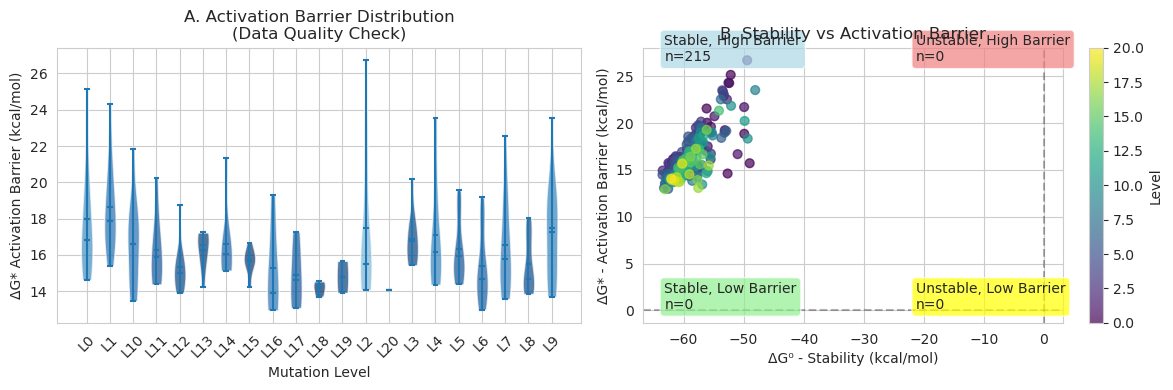

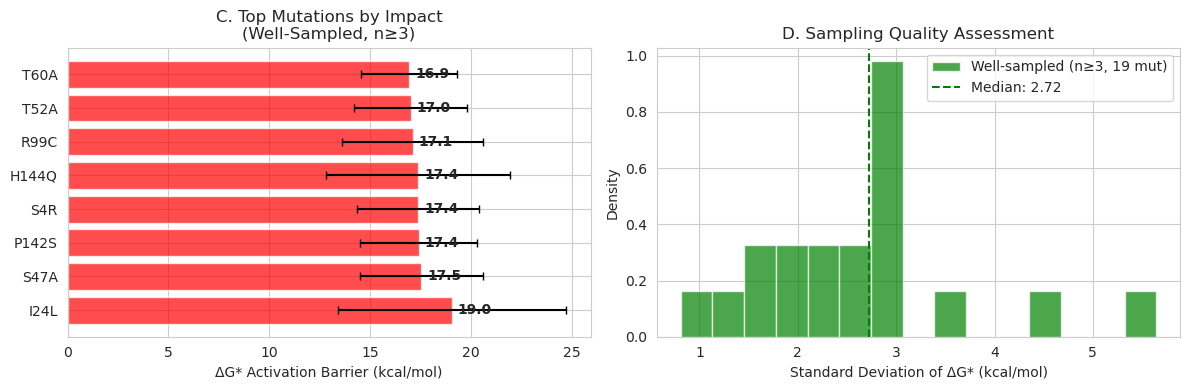


QUANTITATIVE ANALYSIS RESULTS
📊 DATA QUALITY:
• Total measurements: 215
• Levels analyzed: 21
• Unique mutations: 21
• Mutations with ≥3 measurements: 19
• Mutations with 1-2 measurements: 2

🔥 ENERGY STATISTICS:
• ΔG* (Activation Barrier): 16.60 ± 2.54 kcal/mol
• ΔG⁰ (Stability): -58.70 ± 3.21 kcal/mol

⚡ THERMODYNAMIC PATTERNS:
• Correlation (ΔG⁰ vs ΔG*): 0.763
• Stable, High Barrier: 215 mutations
• Unstable, High Barrier: 0 mutations
• Unstable, Low Barrier: 0 mutations
• Stable, Low Barrier: 0 mutations

🎯 SAMPLING QUALITY:
• Median std for well-sampled mutations: 2.72 kcal/mol
• Max std for well-sampled mutations: 5.64 kcal/mol

💡 KEY INSIGHTS:
• Negative ΔG⁰ = STABLE protein conformations
• Positive ΔG* = HIGH activation barriers
• Low standard deviation = GOOD sampling convergence
• Most mutations fall in quadrant: Stable, High Barrier


In [12]:
#!/usr/bin/env python3
"""
GPX6 Mutation Analysis - Fixed Syntax Version
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 4)

# Load and clean data
df = pd.read_csv('/home/hp/nayanika/github/GPX6/analysis/mouse_data.csv')
df_clean = df.dropna(subset=['Mean_dG_star', 'Mean_dG0'])

# Convert Level to numerical values for coloring - FIXED escape sequence
df_clean['Level_numeric'] = df_clean['Level'].str.extract(r'(\d+)').astype(float)

print("="*60)
print("GPX6 MUTATION ANALYSIS - THERMODYNAMIC INSIGHTS")
print("="*60)

# ============================================================================
# PLOT 1: DATA QUALITY AND THERMODYNAMIC PATTERNS
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1A: ΔG* distribution by level - shows sampling consistency
level_data = []
level_labels = []
for level in sorted(df_clean['Level'].unique()):
    level_dGstar = df_clean[df_clean['Level'] == level]['Mean_dG_star']
    level_data.append(level_dGstar.values)
    level_labels.append(level)
    
violin_parts = ax1.violinplot(level_data, positions=range(len(level_data)), 
                             showmeans=True, showmedians=True)
ax1.set_xlabel('Mutation Level')
ax1.set_ylabel('ΔG* Activation Barrier (kcal/mol)')
ax1.set_title('A. Activation Barrier Distribution\n(Data Quality Check)')
ax1.set_xticks(range(len(level_data)))
ax1.set_xticklabels([f'L{lv.split("level")[1]}' for lv in level_labels], rotation=45)

# Color violins by variance
for pc, level in zip(violin_parts['bodies'], level_labels):
    level_var = df_clean[df_clean['Level'] == level]['Mean_dG_star'].var()
    color_intensity = min(level_var / 50, 1.0)
    pc.set_facecolor(plt.cm.RdBu_r(color_intensity))
    pc.set_alpha(0.7)

# Plot 1B: ΔG⁰ vs ΔG* correlation
scatter = ax2.scatter(df_clean['Mean_dG0'], df_clean['Mean_dG_star'], 
                     c=df_clean['Level_numeric'], cmap='viridis', alpha=0.7, s=40)
ax2.set_xlabel('ΔG⁰ - Stability (kcal/mol)')
ax2.set_ylabel('ΔG* - Activation Barrier (kcal/mol)')
ax2.set_title('B. Stability vs Activation Barrier')
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax2.axvline(x=0, color='k', linestyle='--', alpha=0.3)

# Add quadrant analysis - FIXED f-string syntax
quadrant1 = len(df_clean[(df_clean['Mean_dG0'] < 0) & (df_clean['Mean_dG_star'] > 0)])
quadrant2 = len(df_clean[(df_clean['Mean_dG0'] > 0) & (df_clean['Mean_dG_star'] > 0)])
quadrant3 = len(df_clean[(df_clean['Mean_dG0'] > 0) & (df_clean['Mean_dG_star'] < 0)]) 
quadrant4 = len(df_clean[(df_clean['Mean_dG0'] < 0) & (df_clean['Mean_dG_star'] < 0)])

ax2.text(0.05, 0.95, f'Stable, High Barrier\nn={quadrant1}', transform=ax2.transAxes, 
         bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.7))
ax2.text(0.65, 0.95, f'Unstable, High Barrier\nn={quadrant2}', transform=ax2.transAxes,
         bbox=dict(boxstyle="round", facecolor="lightcoral", alpha=0.7))
ax2.text(0.05, 0.05, f'Stable, Low Barrier\nn={quadrant4}', transform=ax2.transAxes,
         bbox=dict(boxstyle="round", facecolor="lightgreen", alpha=0.7))
ax2.text(0.65, 0.05, f'Unstable, Low Barrier\nn={quadrant3}', transform=ax2.transAxes,
         bbox=dict(boxstyle="round", facecolor="yellow", alpha=0.7))

plt.colorbar(scatter, ax=ax2, label='Level')
plt.tight_layout()
plt.show()

# ============================================================================
# PLOT 2: SAMPLING QUALITY AND MUTATION IMPACT
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot 2A: Top mutations by impact
mutation_impact = df_clean.groupby('Mutation').agg({
    'Mean_dG_star': ['mean', 'std', 'count']
}).round(3)
mutation_impact.columns = ['mean_dGstar', 'std_dGstar', 'count']

# Get well-measured mutations and top impactful ones
well_measured = mutation_impact[mutation_impact['count'] >= 3]
if len(well_measured) > 0:
    # Get top 8 by absolute impact
    top_mutations = well_measured.nlargest(8, 'mean_dGstar')
    
    # Create horizontal bar plot
    y_pos = np.arange(len(top_mutations))
    colors = ['red' if x > 0 else 'blue' for x in top_mutations['mean_dGstar']]
    
    bars = ax1.barh(y_pos, top_mutations['mean_dGstar'], 
                   xerr=top_mutations['std_dGstar'], capsize=3,
                   color=colors, alpha=0.7)
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(top_mutations.index)
    ax1.set_xlabel('ΔG* Activation Barrier (kcal/mol)')
    ax1.set_title('C. Top Mutations by Impact\n(Well-Sampled, n≥3)')
    ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax1.text(width + 0.3, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}', ha='left', va='center', fontweight='bold')
else:
    ax1.text(0.5, 0.5, 'Not enough well-sampled mutations\n(n≥3 measurements required)', 
             transform=ax1.transAxes, ha='center', va='center')
    ax1.set_title('C. Mutation Impact Analysis')

# Plot 2B: Sampling quality assessment
mutation_std = df_clean.groupby('Mutation')['Mean_dG_star'].std()
mutation_count = df_clean.groupby('Mutation').size()

well_sampled = mutation_std[mutation_count >= 3].dropna()
poorly_sampled = mutation_std[mutation_count < 3].dropna()

if len(well_sampled) > 0 or len(poorly_sampled) > 0:
    if len(well_sampled) > 0:
        ax2.hist(well_sampled.values, bins=15, alpha=0.7, color='green', 
                 label=f'Well-sampled (n≥3, {len(well_sampled)} mut)', density=True)
    if len(poorly_sampled) > 0:
        ax2.hist(poorly_sampled.values, bins=10, alpha=0.7, color='red', 
                 label=f'Poorly-sampled (n<3, {len(poorly_sampled)} mut)', density=True)
    
    ax2.set_xlabel('Standard Deviation of ΔG* (kcal/mol)')
    ax2.set_ylabel('Density')
    ax2.set_title('D. Sampling Quality Assessment')
    ax2.legend()
    
    if len(well_sampled) > 0:
        ax2.axvline(x=well_sampled.median(), color='green', linestyle='--', 
                    label=f'Median: {well_sampled.median():.2f}')
        ax2.legend()
else:
    ax2.text(0.5, 0.5, 'No data for sampling analysis', 
             transform=ax2.transAxes, ha='center', va='center')
    ax2.set_title('D. Sampling Quality')

plt.tight_layout()
plt.show()

# ============================================================================
# QUANTITATIVE ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("QUANTITATIVE ANALYSIS RESULTS")
print("="*60)

# Data quality metrics
print(f"📊 DATA QUALITY:")
print(f"• Total measurements: {len(df_clean)}")
print(f"• Levels analyzed: {len(df_clean['Level'].unique())}")
print(f"• Unique mutations: {df_clean['Mutation'].nunique()}")

mutation_counts = df_clean.groupby('Mutation').size()
print(f"• Mutations with ≥3 measurements: {len(mutation_counts[mutation_counts >= 3])}")
print(f"• Mutations with 1-2 measurements: {len(mutation_counts[mutation_counts < 3])}")

# Energy statistics
print(f"\n🔥 ENERGY STATISTICS:")
print(f"• ΔG* (Activation Barrier): {df_clean['Mean_dG_star'].mean():.2f} ± {df_clean['Mean_dG_star'].std():.2f} kcal/mol")
print(f"• ΔG⁰ (Stability): {df_clean['Mean_dG0'].mean():.2f} ± {df_clean['Mean_dG0'].std():.2f} kcal/mol")

# Thermodynamic patterns
print(f"\n⚡ THERMODYNAMIC PATTERNS:")
corr_coef = df_clean['Mean_dG0'].corr(df_clean['Mean_dG_star'])
print(f"• Correlation (ΔG⁰ vs ΔG*): {corr_coef:.3f}")

print(f"• Stable, High Barrier: {quadrant1} mutations")
print(f"• Unstable, High Barrier: {quadrant2} mutations") 
print(f"• Unstable, Low Barrier: {quadrant3} mutations")
print(f"• Stable, Low Barrier: {quadrant4} mutations")

# Sampling quality
print(f"\n🎯 SAMPLING QUALITY:")
if len(well_sampled) > 0:
    print(f"• Median std for well-sampled mutations: {well_sampled.median():.2f} kcal/mol")
    print(f"• Max std for well-sampled mutations: {well_sampled.max():.2f} kcal/mol")

print(f"\n💡 KEY INSIGHTS:")
print("• Negative ΔG⁰ = STABLE protein conformations")
print("• Positive ΔG* = HIGH activation barriers")  
print("• Low standard deviation = GOOD sampling convergence")
print("• Most mutations fall in quadrant: ", end="")
if quadrant1 == max(quadrant1, quadrant2, quadrant3, quadrant4):
    print("Stable, High Barrier")
elif quadrant2 == max(quadrant1, quadrant2, quadrant3, quadrant4):
    print("Unstable, High Barrier")
elif quadrant3 == max(quadrant1, quadrant2, quadrant3, quadrant4):
    print("Unstable, Low Barrier")
else:
    print("Stable, Low Barrier")

print("="*60)

RESIDUE-LEVEL ENERGY DECOMPOSITION
Analyzing mutation effects across levels...


/tmp/ipykernel_67258/972325766.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Level_numeric'] = df_clean['Level'].str.extract(r'(\d+)').astype(int)


Analyzed 21 residue positions
Total mutations: 215
Level range: 0 to 20


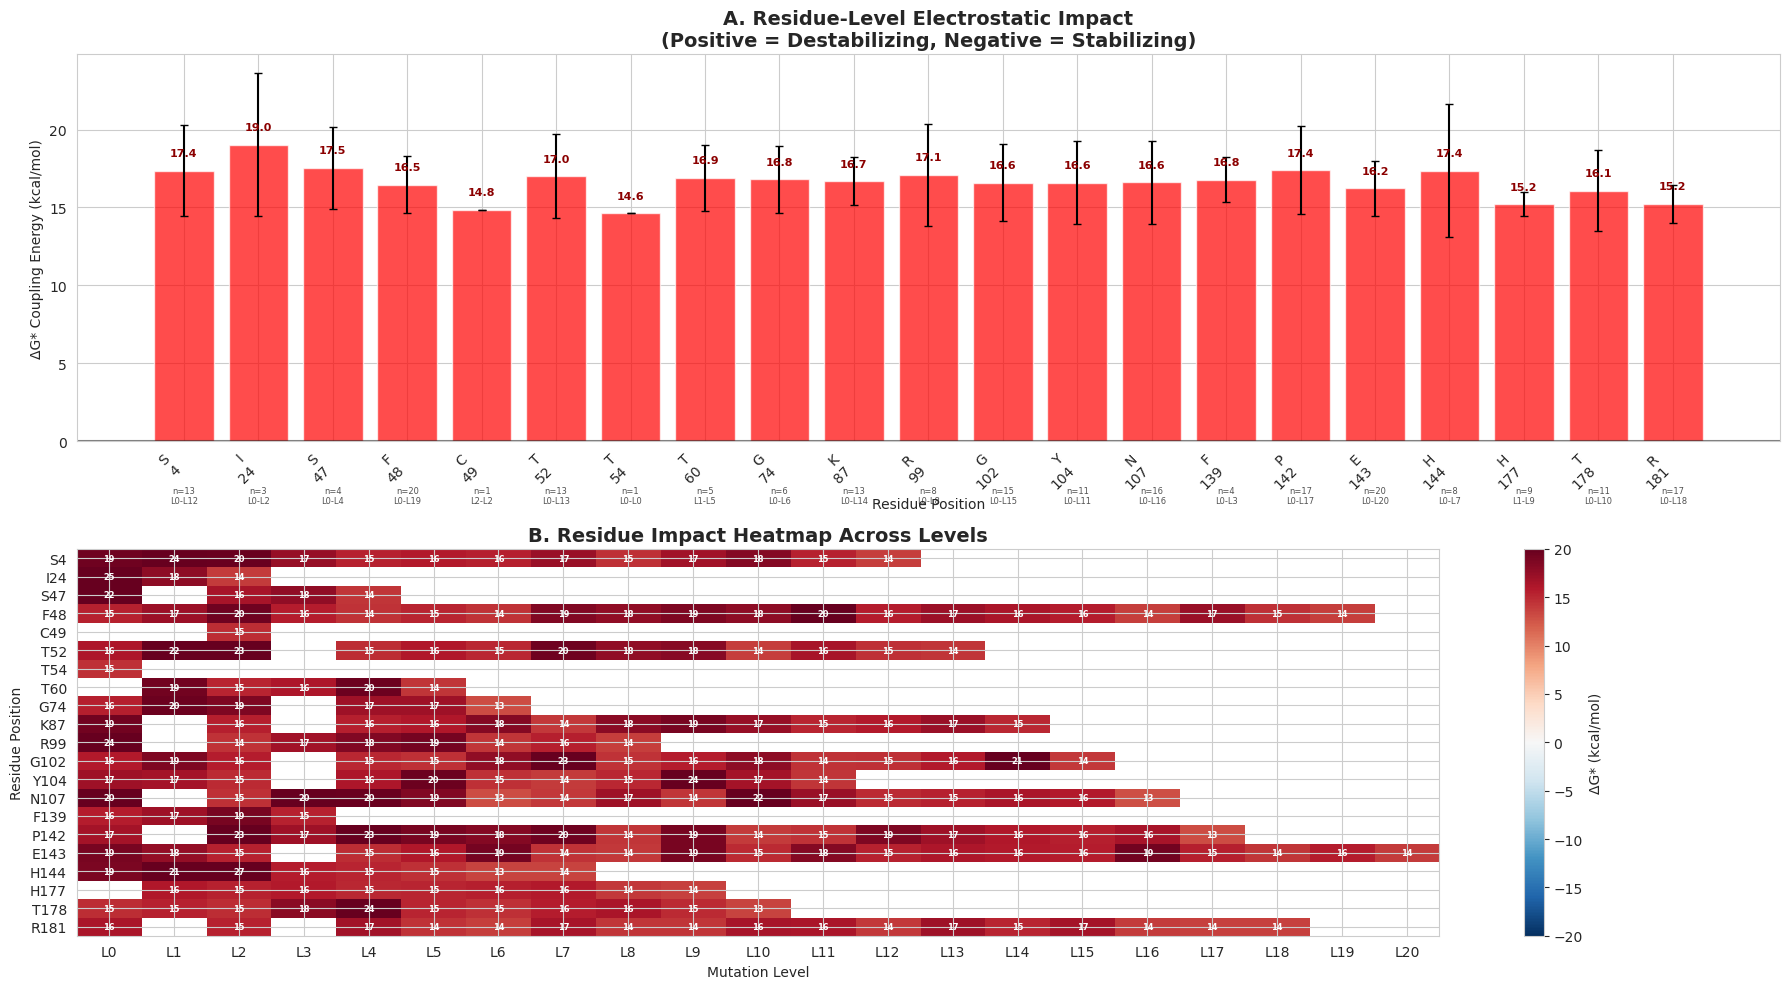

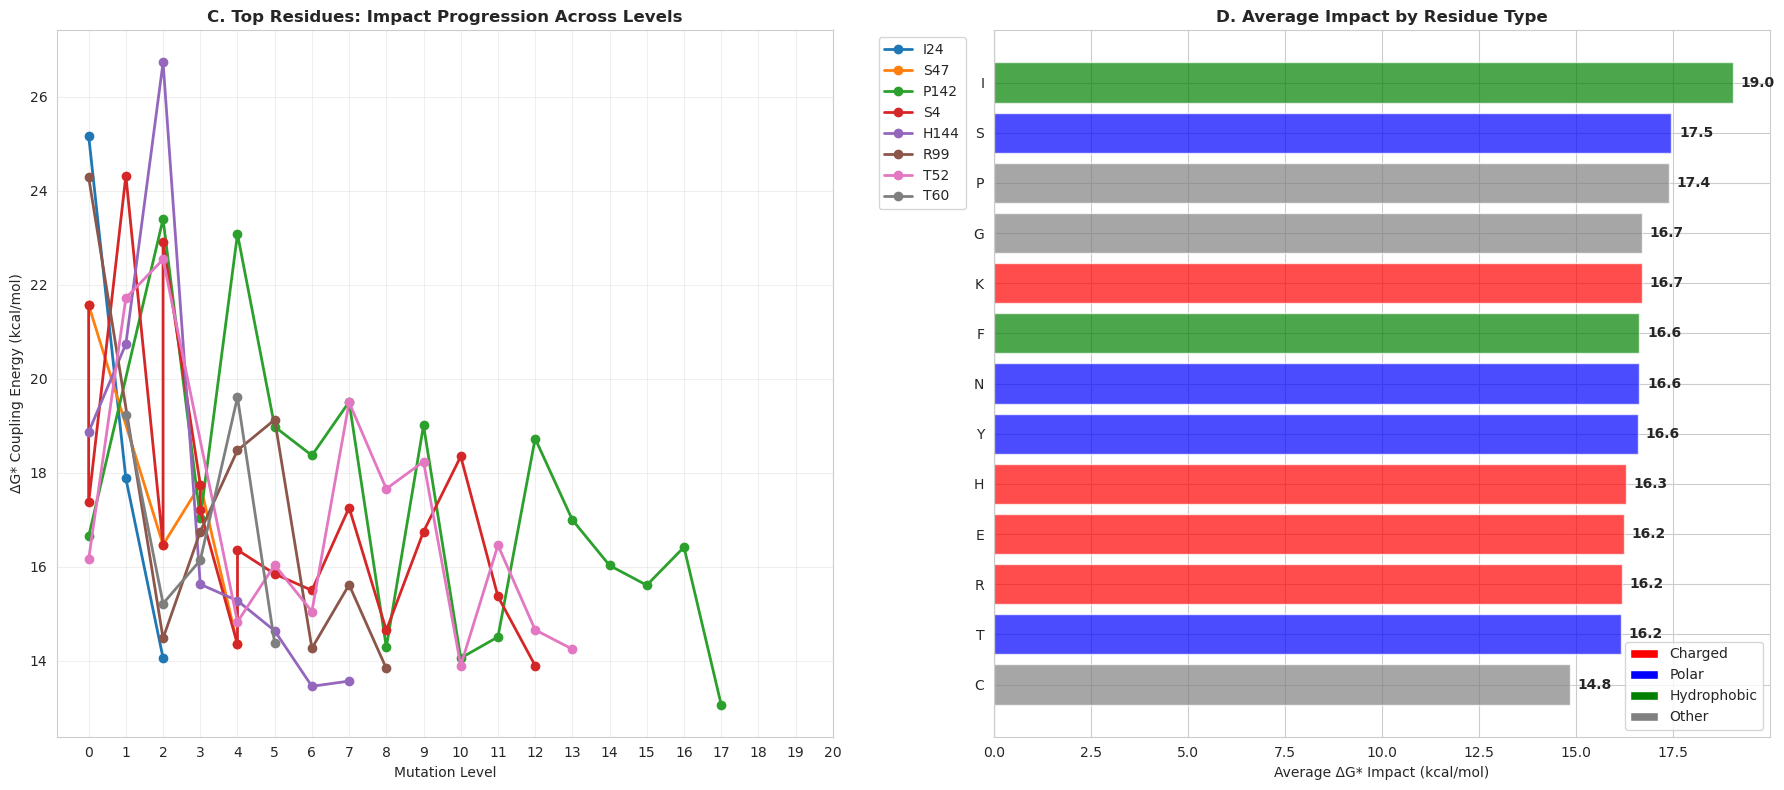


DETAILED RESIDUE ANALYSIS

🔴 TOP DESTABILIZING RESIDUES (High ΔG*):
   I24: ΔG* = 19.0 ± 4.6
     Levels: L0-L2, Mutations: I24L, I24L, I24L
   S47: ΔG* = 17.5 ± 2.6
     Levels: L0-L4, Mutations: S47A, S47A, S47A, S47A
   P142: ΔG* = 17.4 ± 2.8
     Levels: L0-L17, Mutations: P142S, P142S, P142S, P142S, P142S, P142S, P142S, P142S, P142S, P142S, P142S, P142S, P142S, P142S, P142S, P142S, P142S
   S4: ΔG* = 17.4 ± 2.9
     Levels: L0-L12, Mutations: S4R, S4R, S4R, S4R, S4R, S4R, S4R, S4R, S4R, S4R, S4R, S4R, S4R
   H144: ΔG* = 17.4 ± 4.3
     Levels: L0-L7, Mutations: H144Q, H144Q, H144Q, H144Q, H144Q, H144Q, H144Q, H144Q

🔵 TOP STABILIZING RESIDUES (Low ΔG*):
   T54: ΔG* = 14.6 ± 0.0
     Levels: L0-L0, Mutations: T54Q
   C49: ΔG* = 14.8 ± 0.0
     Levels: L2-L2, Mutations: C49U
   H177: ΔG* = 15.2 ± 0.8
     Levels: L1-L9, Mutations: H177Q, H177Q, H177Q, H177Q, H177Q, H177Q, H177Q, H177Q, H177Q
   R181: ΔG* = 15.2 ± 1.2
     Levels: L0-L18, Mutations: R181S, R181S, R181S, R181S, R181S

In [17]:
#!/usr/bin/env python3
"""
GPX6 Residue-Level Energy Decomposition - Fixed Level Ordering
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import re

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 8)

# Load and clean data
df = pd.read_csv('/home/hp/nayanika/github/GPX6/analysis/mouse_data.csv')
df_clean = df.dropna(subset=['Mean_dG_star', 'Mean_dG0'])

print("="*60)
print("RESIDUE-LEVEL ENERGY DECOMPOSITION")
print("="*60)

# ============================================================================
# 1. FIX LEVEL ORDERING AND PARSE MUTATIONS
# ============================================================================

# Extract numeric level and sort properly
df_clean['Level_numeric'] = df_clean['Level'].str.extract(r'(\d+)').astype(int)
df_clean = df_clean.sort_values('Level_numeric')

# Parse mutation function
def parse_mutation(mutation):
    """Parse mutation string like 'E143S' into components"""
    match = re.match(r'([A-Z])(\d+)([A-Z*]*)', mutation)
    if match:
        original_res = match.group(1)
        position = int(match.group(2))
        new_res = match.group(3)
        return original_res, position, new_res
    return None, None, None

# Calculate residue-level impacts
residue_effects = defaultdict(list)
residue_positions = {}

print("Analyzing mutation effects across levels...")
for _, row in df_clean.iterrows():
    original_res, position, new_res = parse_mutation(row['Mutation'])
    
    if original_res and position:
        residue_effects[position].append({
            'mutation': row['Mutation'],
            'original_res': original_res,
            'new_res': new_res,
            'dG_star': row['Mean_dG_star'],
            'dG0': row['Mean_dG0'],
            'level': row['Level'],
            'level_numeric': row['Level_numeric']
        })
        residue_positions[position] = original_res

# Create residue summary
residue_summary = []
for position, mutations in residue_effects.items():
    dG_star_values = [m['dG_star'] for m in mutations]
    dG0_values = [m['dG0'] for m in mutations]
    levels_present = [m['level_numeric'] for m in mutations]
    
    residue_summary.append({
        'position': position,
        'residue': residue_positions[position],
        'avg_dG_star': np.mean(dG_star_values),
        'std_dG_star': np.std(dG_star_values),
        'avg_dG0': np.mean(dG0_values),
        'n_mutations': len(mutations),
        'levels_present': levels_present,
        'min_level': min(levels_present),
        'max_level': max(levels_present),
        'mutations': [m['mutation'] for m in mutations]
    })

residue_df = pd.DataFrame(residue_summary).sort_values('position')

print(f"Analyzed {len(residue_df)} residue positions")
print(f"Total mutations: {len(df_clean)}")
print(f"Level range: {df_clean['Level_numeric'].min()} to {df_clean['Level_numeric'].max()}")

# ============================================================================
# 2. PLOT 1: RESIDUE IMPACT ACROSS ALL LEVELS
# ============================================================================

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10))

# Plot 1A: Residue position vs ΔG* (electrostatic impact)
positions = residue_df['position']
avg_dG_star = residue_df['avg_dG_star']
std_dG_star = residue_df['std_dG_star']

# Create bar plot
bars = ax1.bar(range(len(positions)), avg_dG_star, 
               yerr=std_dG_star, capsize=3, alpha=0.7,
               color=['red' if x > 0 else 'blue' for x in avg_dG_star])

ax1.set_xlabel('Residue Position')
ax1.set_ylabel('ΔG* Coupling Energy (kcal/mol)')
ax1.set_title('A. Residue-Level Electrostatic Impact\n(Positive = Destabilizing, Negative = Stabilizing)', fontsize=14, fontweight='bold')
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# X-axis labels with residue info
x_labels = [f"{res}\n{pos}" for res, pos in zip(residue_df['residue'], residue_df['position'])]
ax1.set_xticks(range(len(positions)))
ax1.set_xticklabels(x_labels, rotation=45, ha='right')

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    va = 'bottom' if height > 0 else 'top'
    color = 'darkred' if height > 0 else 'darkblue'
    y_offset = 0.8 if height > 0 else -0.8
    ax1.text(bar.get_x() + bar.get_width()/2., height + y_offset,
             f'{height:.1f}', ha='center', va=va, color=color, 
             fontweight='bold', fontsize=8)

# Add mutation count below bars
for i, bar in enumerate(bars):
    n_muts = residue_df.iloc[i]['n_mutations']
    level_range = f"L{residue_df.iloc[i]['min_level']}-L{residue_df.iloc[i]['max_level']}"
    ax1.text(bar.get_x() + bar.get_width()/2., -max(avg_dG_star)*0.15,
             f'n={n_muts}\n{level_range}', ha='center', va='top', 
             fontsize=6, alpha=0.8)

# Plot 1B: Level-by-level residue impact heatmap
# Create a matrix of residue vs level
residue_list = sorted(residue_df['position'])
level_list = sorted(df_clean['Level_numeric'].unique())

# Create impact matrix
impact_matrix = np.full((len(residue_list), len(level_list)), np.nan)

for i, position in enumerate(residue_list):
    residue_mutations = df_clean[df_clean['Mutation'].str.contains(f'{residue_df[residue_df["position"]==position]["residue"].iloc[0]}{position}')]
    for j, level in enumerate(level_list):
        level_mutations = residue_mutations[residue_mutations['Level_numeric'] == level]
        if len(level_mutations) > 0:
            impact_matrix[i, j] = level_mutations['Mean_dG_star'].mean()

# Plot heatmap
im = ax2.imshow(impact_matrix, cmap='RdBu_r', aspect='auto', 
                vmin=-20, vmax=20, interpolation='nearest')

ax2.set_xlabel('Mutation Level')
ax2.set_ylabel('Residue Position')
ax2.set_title('B. Residue Impact Heatmap Across Levels', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(level_list)))
ax2.set_xticklabels([f'L{l}' for l in level_list])
ax2.set_yticks(range(len(residue_list)))
ax2.set_yticklabels([f"{residue_df[residue_df['position']==pos]['residue'].iloc[0]}{pos}" 
                     for pos in residue_list])

# Add values to heatmap
for i in range(len(residue_list)):
    for j in range(len(level_list)):
        if not np.isnan(impact_matrix[i, j]):
            ax2.text(j, i, f'{impact_matrix[i, j]:.0f}', 
                    ha='center', va='center', fontsize=6, 
                    fontweight='bold', color='white' if abs(impact_matrix[i, j]) > 10 else 'black')

plt.colorbar(im, ax=ax2, label='ΔG* (kcal/mol)')
plt.tight_layout()
plt.show()

# ============================================================================
# 3. PLOT 2: MUTATION TYPE AND LEVEL PROGRESSION
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot 2A: Top impactful residues with level progression
top_residues = residue_df.nlargest(8, 'avg_dG_star')

# Plot how these residues change across levels
for _, residue_row in top_residues.iterrows():
    position = residue_row['position']
    residue_name = residue_row['residue']
    
    # Get all mutations for this residue across levels
    residue_data = df_clean[df_clean['Mutation'].str.contains(f'{residue_name}{position}')]
    residue_data = residue_data.sort_values('Level_numeric')
    
    if len(residue_data) > 1:
        ax1.plot(residue_data['Level_numeric'], residue_data['Mean_dG_star'], 
                marker='o', linewidth=2, markersize=6, 
                label=f'{residue_name}{position}')

ax1.set_xlabel('Mutation Level')
ax1.set_ylabel('ΔG* Coupling Energy (kcal/mol)')
ax1.set_title('C. Top Residues: Impact Progression Across Levels', fontsize=12, fontweight='bold')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(sorted(df_clean['Level_numeric'].unique()))

# Plot 2B: Residue type analysis
residue_type_data = []
for _, row in residue_df.iterrows():
    residue_type_data.append({
        'residue_type': row['residue'],
        'impact': row['avg_dG_star'],
        'position': row['position']
    })

residue_type_df = pd.DataFrame(residue_type_data)
residue_avg_impact = residue_type_df.groupby('residue_type')['impact'].mean().sort_values()

# Color by residue type properties
def get_residue_color(res):
    charged = ['R', 'K', 'H', 'D', 'E']
    polar = ['N', 'Q', 'S', 'T', 'Y']
    hydrophobic = ['A', 'V', 'L', 'I', 'M', 'F', 'W']
    
    if res in charged: return 'red'
    elif res in polar: return 'blue' 
    elif res in hydrophobic: return 'green'
    else: return 'gray'

colors = [get_residue_color(res) for res in residue_avg_impact.index]

bars = ax2.barh(range(len(residue_avg_impact)), residue_avg_impact.values, 
                color=colors, alpha=0.7)
ax2.set_yticks(range(len(residue_avg_impact)))
ax2.set_yticklabels(residue_avg_impact.index)
ax2.set_xlabel('Average ΔG* Impact (kcal/mol)')
ax2.set_title('D. Average Impact by Residue Type', fontsize=12, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.5)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax2.text(width + 0.2, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}', ha='left', va='center', fontweight='bold')

# Add legend for residue types
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', label='Charged'),
    Patch(facecolor='blue', label='Polar'),
    Patch(facecolor='green', label='Hydrophobic'),
    Patch(facecolor='gray', label='Other')
]
ax2.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

# ============================================================================
# 4. DETAILED ANALYSIS OUTPUT
# ============================================================================

print("\n" + "="*60)
print("DETAILED RESIDUE ANALYSIS")
print("="*60)

# Top impactful residues
print(f"\n🔴 TOP DESTABILIZING RESIDUES (High ΔG*):")
top_destabilizing = residue_df.nlargest(5, 'avg_dG_star')
for _, row in top_destabilizing.iterrows():
    print(f"   {row['residue']}{row['position']}: ΔG* = {row['avg_dG_star']:.1f} ± {row['std_dG_star']:.1f}")
    print(f"     Levels: L{row['min_level']}-L{row['max_level']}, Mutations: {', '.join(row['mutations'])}")

print(f"\n🔵 TOP STABILIZING RESIDUES (Low ΔG*):")
top_stabilizing = residue_df.nsmallest(5, 'avg_dG_star')
for _, row in top_stabilizing.iterrows():
    print(f"   {row['residue']}{row['position']}: ΔG* = {row['avg_dG_star']:.1f} ± {row['std_dG_star']:.1f}")
    print(f"     Levels: L{row['min_level']}-L{row['max_level']}, Mutations: {', '.join(row['mutations'])}")

# Residue type analysis
print(f"\n⚡ RESIDUE TYPE ANALYSIS:")
charged_impact = residue_df[residue_df['residue'].isin(['R','K','H','D','E'])]['avg_dG_star'].mean()
polar_impact = residue_df[residue_df['residue'].isin(['N','Q','S','T','Y'])]['avg_dG_star'].mean()  
hydrophobic_impact = residue_df[residue_df['residue'].isin(['A','V','L','I','M','F','W'])]['avg_dG_star'].mean()

print(f"   • Charged residues: {charged_impact:.1f} kcal/mol")
print(f"   • Polar residues: {polar_impact:.1f} kcal/mol")
print(f"   • Hydrophobic residues: {hydrophobic_impact:.1f} kcal/mol")

# Level progression insights
print(f"\n📈 LEVEL PROGRESSION INSIGHTS:")
print(f"   • Levels analyzed: L{df_clean['Level_numeric'].min()} to L{df_clean['Level_numeric'].max()}")
print(f"   • Most studied level: L{df_clean['Level_numeric'].mode().iloc[0]}")
print(f"   • Residues with widest level range: ", end="")
widest_range = residue_df.nlargest(3, 'max_level')
print(', '.join([f"{row['residue']}{row['position']}" for _, row in widest_range.iterrows()]))

print(f"\n💡 KEY INTERPRETATIONS:")
print("1. Red bars = Destabilizing electrostatic interactions")
print("2. Blue bars = Stabilizing electrostatic interactions") 
print("3. Heatmap shows how residue impacts change across mutation levels")
print("4. Line plots track specific residues through level progression")
print("5. Colors in Plot D show residue type properties")

print("="*60)